#### Uninstall and purge cache

In [ ]:
# !pip uninstall -y torch torchvision torchaudio lightning torchmetrics fusilli
# !pip uninstall -y pandas numpy matplotlib Pillow openpyxl scikit-learn

In [ ]:
# !pip uninstall -y lightning pytorch-lightning lightning-cloud lightning-utilities

In [ ]:
# !pip cache purge

In [ ]:
import sys
print(sys.executable)

In [ ]:
conda list

In [ ]:
!pip list | grep lightning
!conda list | grep lightning

#### Proper installs

In [26]:
import pkg_resources

packages = [
    "torch", "torchvision", "lightning", "pytorch-lightning","torchmetrics",
    "pandas", "numpy", "matplotlib", "tqdm", "Pillow",
    "openpyxl", "scikit-learn", "fusilli"
]

for pkg in packages:
    try:
        version = pkg_resources.get_distribution(pkg).version
        print(f"{pkg}: {version}")
    except Exception:
        print(f"{pkg}: not installed")

torch: 2.0.0
torchvision: 0.15.1
lightning: 2.2.0
pytorch-lightning: 2.3.3
torchmetrics: 0.11.4
pandas: 2.3.3
numpy: 1.26.4
matplotlib: 3.10.7
tqdm: 4.67.1
Pillow: 10.1.0
openpyxl: 3.1.5
scikit-learn: 1.3.2
fusilli: 1.2.4.dev17


In [ ]:
!pip install numpy==1.26.4 pandas matplotlib Pillow==10.1.0 openpyxl scikit-learn==1.3.2

In [ ]:
!pip install torch==2.0 lightning==2.2 torchvision torchmetrics

In [ ]:
!pip install git+https://github.com/florencejt/fusilli.git

In [81]:
import os
import torch
import pandas as pd
from pathlib import Path
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import tensor

from fusilli.data import prepare_fusion_data
from fusilli.train import train_and_save_models
from fusilli.fusionmodels.tabularimagefusion.concat_img_maps_tabular_maps import ConcatImageMapsTabularMaps
from fusilli.eval import RealsVsPreds, ConfusionMatrix, ModelComparison
from fusilli.fusionmodels.unimodal.image import ImgUnimodal
from fusilli.fusionmodels.unimodal.tabular1 import Tabular1Unimodal

In [3]:
# import pkgutil, sys
# print([m for m in pkgutil.iter_modules() if "lightning" in m.name])

In [4]:
# print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

NVIDIA A100-SXM4-80GB


In [21]:
# !pip freeze > requirements.txt

In [ ]:
# !pip uninstall -y fusilli
# !pip install git+https://github.com/florencejt/fusilli.git # NOT THIS

# !pip install fusilli==1.2.3  DO NO INSTALL THIS - training_modifications not enabled

In [ ]:
# !pip install lightning==1.9.5
# !pip install # torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128 IGNORE FOR NOW
# !pip install openpyxl torchvision

In [ ]:
# !pip uninstall -y lightning pytorch-lightning
# !pip install lightning==2.2
# !pip install pytorch-lightning==2.2 DO NOT INSTALL THIS need to use lightning, not pytorch-lightning

## Data preprocessing

In [6]:
# os.chdir("..")
# print(os.getcwd())

In [61]:
print('cwd (base):', os.getcwd(),'\n')

# open and load csv
base_dir = Path("Knee X-ray")
excel_path = base_dir / "patient details.xlsx"
df = pd.read_excel(excel_path)

column_names = list(df.columns)
print("df shape:", df.shape,'\n')
print('df cols: ', column_names)

cwd (base): /home/kumar65 

df shape: (243, 28) 

df cols:  ['S.No', 'Patient Id', 'Joint Pain:', 'Gender', 'Age', 'Menopause Age', 'height  (meter)', 'Weight (KG) ', 'Smoker', 'Alcoholic', 'Diabetic', 'Hypothyroidism', 'Number of Pregnancies', 'Seizer Disorder', 'Estrogen Use', 'Occupation ', 'History of Fracture', 'Dialysis:', 'Family History of Osteoporosis', 'Maximum Walking distance (km)', 'Daily Eating habits', 'Medical History', 'T-score Value', 'Z-Score Value', 'BMI: ', 'Site', 'Obesity', 'Diagnosis']


In [62]:
# strip leading/trailing spaces
df['Diagnosis'] = df['Diagnosis'].str.strip()
df["Patient Id"] = df["Patient Id"].astype(str).str.strip()

image_paths = []
for _, row in df.iterrows():
    diagnosis = row["Diagnosis"]
    pid = row["Patient Id"]

    if pd.isna(diagnosis) or pd.isna(pid):
        image_paths.append(None)
        continue

    folder = base_dir / diagnosis

    # Try all possible common extensions
    found_path = None
    for ext in ["jpg", "jpeg", "JPG", "JPEG"]:
        candidate = folder / f"{pid}.{ext}"
        if candidate.exists():
            found_path = candidate
            break

    if found_path:
        image_paths.append(str(found_path))
    else:
        print(f"WARNING image {pid}.JPEG not found in {folder} folder")
        image_paths.append(None)

df["image_path"] = image_paths

WARNING image N37.JPEG not found in Knee X-ray/normal folder


In [63]:
# clear up & remove missing data
before = len(df)
df = df.dropna(subset=["image_path"])
after = len(df)
print(f"Removed {before - after} rows with missing images. Remaining: {after}\n")

# map 3 diagnoses to int identifiers
label_map = {"normal": 0, "osteopenia": 1, "osteoporosis": 2}
df["prediction_label"] = df["Diagnosis"].map(label_map)

#------------------------------------ change this when changing to 3-class

# BINARY labels -- normal vs low BMD (Osteopenia + Osteoporosis)
# df["prediction_label"] = df["Diagnosis"].apply(lambda x: 0 if x == "normal" else 1)
df = df.rename(columns={
    "Patient Id": "ID",
})
#------------------------------------

# save results in csv
mapped_csv = base_dir / "mapped_patient_details.csv"
df.to_csv(mapped_csv, index=False)
print(f"Saved mapped metadata in {mapped_csv}...\n")

#sanity check
print(df[["ID", "Diagnosis", "image_path"]].head())

Removed 4 rows with missing images. Remaining: 239

Saved mapped metadata in Knee X-ray/mapped_patient_details.csv...

    ID   Diagnosis                      image_path
0  OP1  osteopenia  Knee X-ray/osteopenia/OP1.JPEG
1  OP2  osteopenia  Knee X-ray/osteopenia/OP2.JPEG
2  OP3  osteopenia  Knee X-ray/osteopenia/OP3.JPEG
3  OP4  osteopenia  Knee X-ray/osteopenia/OP4.JPEG
4  OP5  osteopenia  Knee X-ray/osteopenia/OP5.JPEG


## Fusilli

In [64]:
# 0 = Normal, 1 = Low BMD (Osteopenia + Osteoporosis)
df["prediction_label"].value_counts()

prediction_label
1    154
2     49
0     36
Name: count, dtype: int64

### Move all images to .pt tensor for loading in to Fusili

In [65]:
# df = pd.read_csv(mapped_csv)
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.Grayscale(num_output_channels=1),
#     transforms.ToTensor()
# ])

# images, valid_idx = [], []
# for i, row in tqdm(df.iterrows(), total=len(df)):
#     p = Path(row["image_path"])
#     if not p.exists(): continue
#     img = Image.open(p).convert("RGB")
#     images.append(transform(img))
#     valid_idx.append(i)

# image_tensor = torch.stack(images)
# torch.save(image_tensor, base_dir / "images.pt")
# df = df.loc[valid_idx].reset_index(drop=True)
# df.to_csv(mapped_csv, index=False)

# print("Saved image tensor:", base_dir / "images.pt", "shape:", image_tensor.shape)
from torchvision import transforms

base_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])
augment_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05,0.05)),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

images, valid_idx = [], []
for i, row in tqdm(df.iterrows(), total=len(df)):
    p = Path(row["image_path"])
    if not p.exists():
        continue
    img = Image.open(p).convert("RGB")
    images.append(base_transform(img))
    valid_idx.append(i)

    if row["prediction_label"] in [0, 2]:
        for _ in range(3):
            images.append(augment_transform(img))
            valid_idx.append(i)

image_tensor = torch.stack(images)
torch.save(image_tensor, base_dir / "images_augmented.pt")


100%|██████████| 239/239 [02:18<00:00,  1.72it/s]


In [66]:
df = df.loc[valid_idx].reset_index(drop=True)
df.to_csv(mapped_csv, index=False)

In [91]:
print("Saved image tensor:", base_dir / "images.pt", "shape:", image_tensor.shape)

Saved image tensor: Knee X-ray/images.pt shape: torch.Size([494, 1, 224, 224])


In [67]:
# print(df.dtypes)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("numeric columns:", numeric_cols)

numeric columns: ['S.No', 'Age', 'height  (meter)', 'Weight (KG) ', 'Number of Pregnancies', 'Maximum Walking distance (km)', 'T-score Value', 'Z-Score Value', 'BMI: ', 'prediction_label']


In [68]:
tabular_features = ['Age', 'height  (meter)', 'Weight (KG) ',
                    'Number of Pregnancies', 'Maximum Walking distance (km)',
                    'T-score Value', 'Z-Score Value', 'BMI: ']
tabular_features += ["ID", "prediction_label"]
df_numeric  = df[tabular_features]
df_numeric = df_numeric.dropna()
df_numeric.to_csv("Knee X-ray/mapped_patient_details_numeric.csv", index=False)

In [86]:
# data_paths = {
#     "tabular1": "Knee X-ray/mapped_patient_details_numeric.csv",
#     "tabular2": "",
#     "image": "Knee X-ray/images.pt",
# }
data_paths = {
    "tabular1": "Knee X-ray/mapped_patient_details_numeric.csv",
    "tabular2": "",
    "image": "Knee X-ray/images_augmented.pt",
}


output_paths = {
    "checkpoints": "outputs/checkpoints",
    "losses": "outputs/losses",
    "figures": "outputs/figures",
}
for p in output_paths.values():
    os.makedirs(p, exist_ok=True)

In [70]:
data_module = prepare_fusion_data(
    prediction_task="multiclass",
    fusion_model=ConcatImageMapsTabularMaps,
    data_paths=data_paths,
    output_paths=output_paths,
    batch_size=8,
    test_size=0.2,
    multiclass_dimensions=3,
    image_downsample_size=(224, 224),  # default for CNNs
    num_workers=4
)

In [71]:
# df_counts = df_numeric['prediction_label'].value_counts()
# weights = df_numeric['prediction_label'].apply(lambda x: 1/class_counts[x]).values
# pos_weight = tensor(weight_for_0)
class_counts = df_numeric['prediction_label'].value_counts().sort_index()
total = class_counts.sum()
weights = total / (len(class_counts) * class_counts)
weights = torch.tensor(weights.values, dtype=torch.float32).cuda()
print(weights)

tensor([1.3846, 0.7826, 1.0000], device='cuda:0')


In [72]:
!rm -rf outputs/losses/ConcatImageMapsTabularMaps

trained_model = train_and_save_models(
    data_module=data_module,
    fusion_model=ConcatImageMapsTabularMaps,
    training_modifications={
        "accelerator": "gpu", 
        "devices": 1,       # number of GPUs
        # "loss_params": {
        #     "weight": weights
        # },
        "precision": 16,    # mixed precision
    },
    max_epochs=30,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kumar65/outputs/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | ConcatImageMapsTabularMaps | 2.8 M 
-----------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.233    Total estimated model params size (MB)


Epoch 0:  32%|███▏      | 7/22 [00:00<00:01, 14.88it/s, v_num=Maps]

/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Epoch 15:  18%|█▊        | 4/22 [00:01<00:08,  2.16it/s, v_num=Maps, val_loss=0.543, train_loss=0.649] 

/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


Epoch 29: 100%|██████████| 22/22 [00:04<00:00,  4.84it/s, v_num=Maps, val_loss=0.381, train_loss=0.469]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 22/22 [00:04<00:00,  4.60it/s, v_num=Maps, val_loss=0.381, train_loss=0.469]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         AUROC_val         │    0.9657456874847412     │
│       Accuracy_val        │    0.8139534592628479     │
│         val_loss          │    0.3807280361652374     │
└───────────────────────────┴───────────────────────────┘

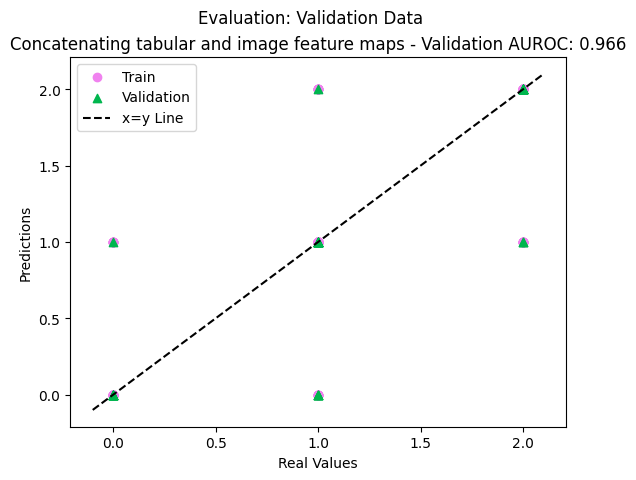

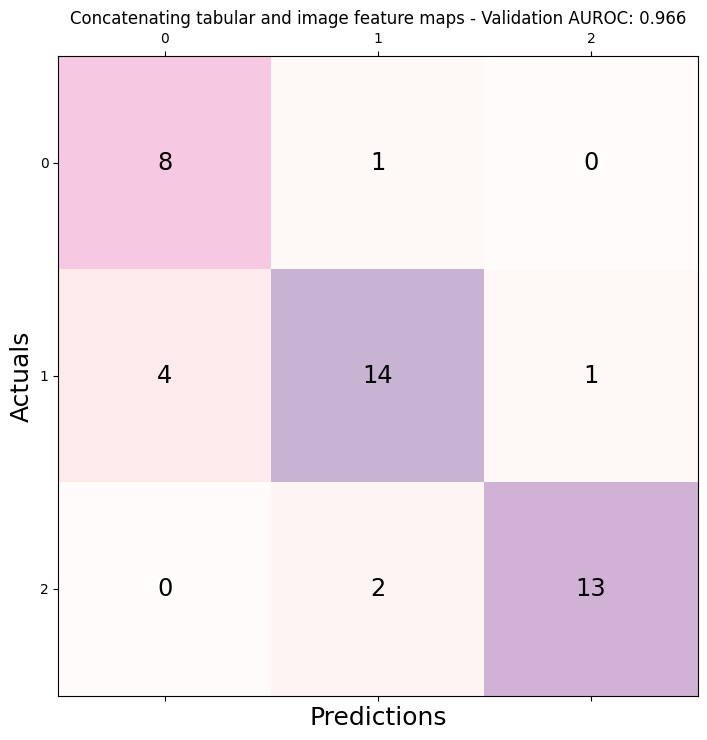

In [73]:
RealsVsPreds.from_final_val_data(trained_model)
ConfusionMatrix.from_final_val_data(trained_model)
plt.show()

In [42]:
from lightning.pytorch.callbacks import ModelCheckpoint
import inspect
print(inspect.signature(ModelCheckpoint.__init__))

(self, dirpath: Union[str, pathlib.Path, NoneType] = None, filename: Optional[str] = None, monitor: Optional[str] = None, verbose: bool = False, save_last: Optional[Literal[True, False, 'link']] = None, save_top_k: int = 1, save_weights_only: bool = False, mode: str = 'min', auto_insert_metric_name: bool = True, every_n_train_steps: Optional[int] = None, train_time_interval: Optional[datetime.timedelta] = None, every_n_epochs: Optional[int] = None, save_on_train_epoch_end: Optional[bool] = None, enable_version_counter: bool = True)


In [40]:
# !pip list

In [41]:
# !conda list

In [75]:
# !rm -rf outputs/losses/ConcatImageMapsTabularMaps

trained_model_wts = train_and_save_models(
    data_module=data_module,
    fusion_model=ConcatImageMapsTabularMaps,
    training_modifications={
        "accelerator": "gpu", 
        "devices": 1,       # number of GPUs
        "loss_params": {
            "weight": weights
        },
        "precision": 16,    # mixed precision
    },
    max_epochs=30,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | ConcatImageMapsTabularMaps | 2.8 M 
-----------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.233    Total estimated model params size (MB)


Epoch 0:  18%|█▊        | 4/22 [00:00<00:01,  9.68it/s, v_num=Maps]

/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


Epoch 29: 100%|██████████| 22/22 [00:04<00:00,  4.77it/s, v_num=Maps, val_loss=0.442, train_loss=0.368]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 22/22 [00:04<00:00,  4.45it/s, v_num=Maps, val_loss=0.442, train_loss=0.368]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         AUROC_val         │     0.937495231628418     │
│       Accuracy_val        │    0.7906976938247681     │
│         val_loss          │    0.44198381900787354    │
└───────────────────────────┴───────────────────────────┘

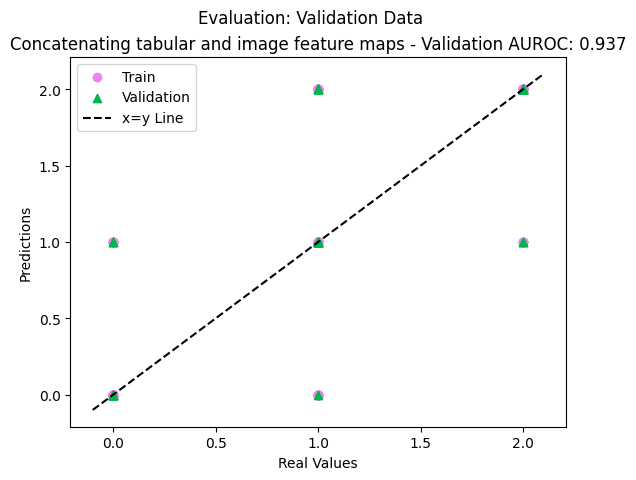

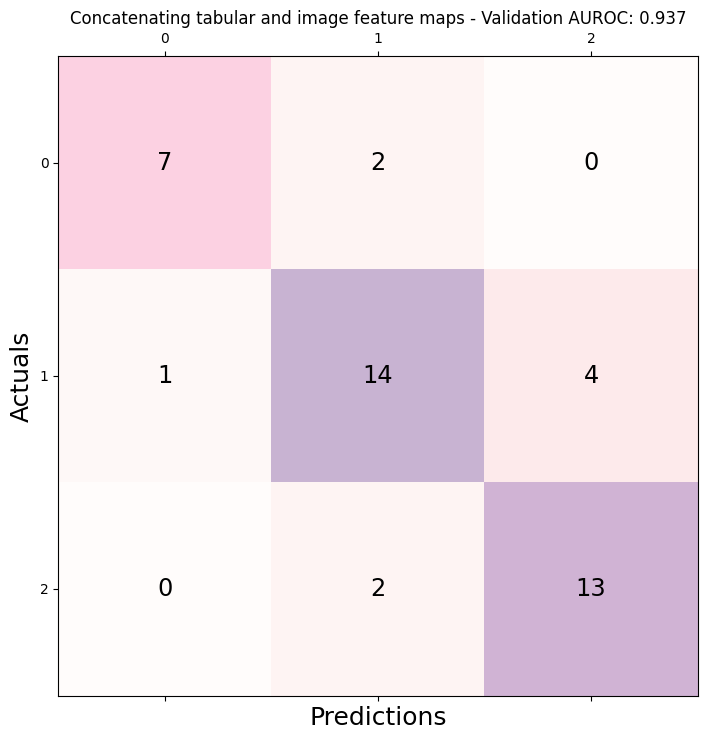

In [76]:
RealsVsPreds.from_final_val_data(trained_model_wts)
ConfusionMatrix.from_final_val_data(trained_model_wts)
plt.show()

## Model comparison

In [ ]:
# TBD